<a href="https://colab.research.google.com/github/94spinoza/Code-Blocks/blob/main/Company_Bankruptcy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"hyeonchunglee","key":"4985f907818830f18663d6ce6537fa9d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 파일 다운로드
!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

company-bankruptcy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip company-bankruptcy-prediction.zip

Archive:  company-bankruptcy-prediction.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_origin = pd.read_csv('./data.csv')
target = 'Bankrupt?'


## 기준 모델
base_accuracy = df_origin[target].value_counts(normalize=True)[0]
print("기준모델 정확도: ", base_accuracy)

기준모델 정확도:  0.967737204868749


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## Oversampling 통해 데이터 편향 해결
oversample = SMOTE(random_state=2)

df, df_test = train_test_split(df_origin, test_size=0.2)

X_a = df.drop(labels=[target], axis=1)
y_a = df[target]

X, y = oversample.fit_resample(X_a, y_a)
X = pd.DataFrame(X, columns=X_a.columns)
y = pd.DataFrame(y, columns=['Bankruptcy?'])

print("Oversampling 이후 기준모델 정확도: ", y.value_counts(normalize=True)[0])

Oversampling 이후 기준모델 정확도:  Bankruptcy?
0              0.5
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [6]:
## Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
pip install category_encoders

In [8]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## Random Forest Classifier
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(boo...p=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                        

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4223
           1       1.00      1.00      1.00      4231

    accuracy                           1.00      8454
   macro avg       1.00      1.00      1.00      8454
weighted avg       1.00      1.00      1.00      8454

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1061
           1       0.96      0.99      0.98      1053

    accuracy                           0.98      2114
   macro avg       0.98      0.98      0.98      2114
weighted avg       0.98      0.98      0.98      2114

AUC: 0.9773476078848369


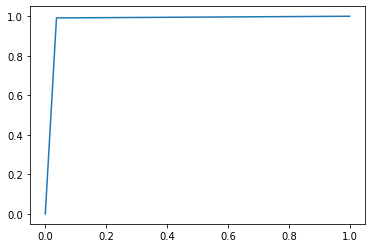

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

## 데이터 예측하기
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

## Confusion Matrix 출력
print(classification_report(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [17]:
pip install eli5

     |████████████████████████████████| 112kB 5.4MB/s 


In [12]:
from sklearn.pipeline import Pipeline
import warnings
import eli5
from eli5.sklearn import PermutationImportance

## Permutation Importance 활용
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe_per = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

pipe_per.fit(X_train, y_train)


## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_per.named_steps['rf'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_test_transformed = pipe_per.named_steps['preprocessing'].transform(X_test)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [13]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

 Non-industry income and expenditure/revenue   -0.002081
 Borrowing dependency                          -0.001703
 Retained Earnings to Total Assets             -0.001514
 Interest-bearing debt interest rate           -0.001514
 Liability to Equity                           -0.001514
                                                  ...   
 Cash Turnover Rate                             0.001041
 Total assets to GNP price                      0.001135
 Debt ratio %                                   0.001230
 Contingent liabilities/Net worth               0.001230
 Interest Expense Ratio                         0.001798
Length: 95, dtype: float64

In [14]:
## 중요하지 않은 변수 삭제
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_test_selected = X_test[features]


## 삭제 후 새로운 Pipeline
pipe_sel = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe_sel.fit(X_train_selected, y_train)

print('시험 정확도: ', pipe_sel.score(X_test_selected, y_test))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[Pipeline] ................ (step 2 of 2) Processing rf, total=   2.7s
시험 정확도:  0.9725638599810785


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1061
           1       0.96      0.99      0.97      1053

    accuracy                           0.97      2114
   macro avg       0.97      0.97      0.97      2114
weighted avg       0.97      0.97      0.97      2114

AUC: 0.9726350725408217


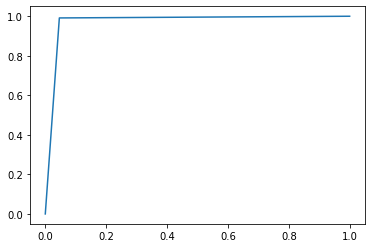

In [15]:
## Confusion Matrix 출력
y_test_selected_pred = pipe_sel.predict(X_test_selected)
print(classification_report(y_test,y_test_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

0    0.964076
1    0.035924
Name: Bankrupt?, dtype: float64
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       0.67      0.22      0.33         9

    accuracy                           0.97       273
   macro avg       0.82      0.61      0.66       273
weighted avg       0.96      0.97      0.96       273

AUC: 0.6092171717171718


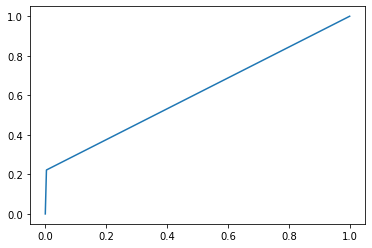

In [22]:
## 원래 데이터에 모델 대입해보기
X_origin = df_test.drop(labels=[target], axis=1)[features]
y_origin = df_test[target]


## 기준모델
base_accuracy_origin = df_test[target].value_counts(normalize=True)
print(base_accuracy_origin)

### 기본적인 모델
pipe_new = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

# Train & Test 분리 및 학습
X_origin_train, X_origin_test, y_origin_train, y_origin_test = train_test_split(X_origin, y_origin, test_size=0.2)
pipe_new.fit(X_origin_train, y_origin_train)

## Confusion Matrix 출력
y_origin_test_pred = pipe_new.predict(X_origin_test)
print(classification_report(y_origin_test, y_origin_test_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_origin_test, y_origin_test_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1315
           1       0.39      0.61      0.48        49

    accuracy                           0.95      1364
   macro avg       0.69      0.79      0.73      1364
weighted avg       0.96      0.95      0.96      1364

AUC: 0.7886319546830138


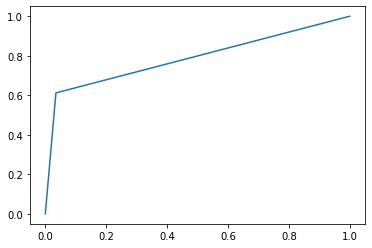

In [23]:
### 학습이 된 모델
## Confusion Matrix 출력
y_origin_pred = pipe_sel.predict(X_origin)
print(classification_report(y_origin, y_origin_pred))


## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_origin, y_origin_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)